# **Clasificación Binaria de Nódulos Pulmonares**

En esta sección se pretende resolver la tarea de **Clasificación** Binaria para determinar la presencia o ausencia de Nódulos Pulmonares en radiografías mediante 4 Modelos: una **red Convolucional** diseñada desde cero, **ResNet50**, **DenseNet121** y **EfficientNet-B0**. 

El conjunto de Datos se divide en 80% para el Entrenamiento y 20% para el Test, utilizando una resolución de 448×448 píxeles y un Batch Size de 32 porque se ha determinado que ofrece un buen rendimiento por calidad de los resultados obtenidos. 

El rendimiento se evalúa principalmente mediante el **AUC-ROC**, pero también se calcula el Accuracy, Precision, Recall y F1-Score. Además, se aplican Pesos de clase y **Early Stopping** para un Entrenamiento más Eficiente y evitando seguir entrenando innecesariamente.

---

## **Preparación del Entorno y Datos**

### **Configuración Inicial**
Se carga la configuración global, las variables globales y las rutas a los archivos y carpetas necesarias. También se muestra el dispositivo disponible y los hiperparámetros principales.

In [1]:
# Configuración global
import sys

sys.path.append("..")  # subimos un nivel para ver la carpeta src
from src.config import *

print(f"Configuración Cargada, Dispositivo = {DEVICE}")
print(f"Resolución = {IMAGE_SIZE}, Batch Size = {BATCH_SIZE}")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import (
    ResNet50_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from pathlib import Path
import SimpleITK as sitk
from PIL import Image

RESULTS_DIR.mkdir(exist_ok=True)
print("\nEntorno preparado para la Clasificación")

Configuración Cargada, Dispositivo = cuda
Resolución = (448, 448), Batch Size = 32

Entorno preparado para la Clasificación


### **Definición del Dataset**
Se crea la clase DatasetClasificacion, que se encarga de cargar las imágenes .mha, redimensionarlas, aplicarles las transformaciones pertinentes y devolverlas junto con su etiqueta (con o sin nódulo).

In [2]:
# Dataset personalizado para la Clasificación Binaria

from src.funcDatos import load_mha_image, preprocess_image

# Cada elemento es una imagen preprocesada (tensor) y su etiqueta (0 = sin nódulo, 1 = con nódulo)
class DatasetClasificacion(Dataset):

    def __init__(self, df, transform=None):

        # Reiniciamos el índice para tener un acceso seguro por posición
        self.df = df.reset_index(drop=True)
        self.transform = transform
    

    # Devuelve el número total de imágenes en el Dataset
    def __len__(self):
        return len(self.df)
    
    # Devuelve un elemento correspondiente al índice idx
    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        img_path = IMAGE_DIR / row['img_name']
        
        # Cargamos la imagen .mha y la redimensionamos al tamaño IMAGE_SIZE
        image = load_mha_image(img_path, target_size=IMAGE_SIZE)
        
        # Aplicamos las transformaciones si se especifican
        image = preprocess_image(image, self.transform)
        
        # Convertimos la etiqueta a tensor long (necesario para CrossEntropyLoss)
        label = torch.tensor(row['label'], dtype=torch.long)
        
        return image, label

### **Transformaciones de Imágenes**
Se define el conjunto de transformaciones para el entrenamiento y el conjunto de transformaciones para el test, que incluyen normalización.

In [3]:
# Definimos las transformaciones

# Transformaciones para el Entrenamiento
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),                 # Giro horizontal aleatorio
    transforms.RandomRotation(10),                          # Rotación aleatoria de 10 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Variaciones aleatorias en brillo y contraste
    transforms.ToTensor(),                                  
    transforms.Normalize(                                   # Normalizamos con media y std (desviación estándar)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Transformaciones para el Test
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### **División del Dataset y Creación de los Dataloaders**
Se separa el conjunto de datos en un dataset para el entrenamiento (80%) y un dataset para el test (20%) de forma estratificada para mantener la proporción de clases.

También se generan los DataLoaders para el entrenamiento y para el test. El de entrenamiento mezcla los datos en cada epoch para obtener aleatoriedad, pero en el de test no es necesario.

In [4]:
# Split de Datos

from src.funcDatos import get_train_test_split

# Hacemos el split 80/20
train_df, test_df, _ = get_train_test_split(test_size=0.2, random_state=42)

# Creamos los Datasets para el Entrenamiento y para el Test
train_dataset = DatasetClasificacion(train_df, transform=train_transform)
test_dataset  = DatasetClasificacion(test_df,  transform=val_transform)


# Creamos los Data Loader

# DataLoader para el Entrenamiento
# shuffle = True para evitar el Overfitting
# pin_memory = True para acelerar la transferencia a la GPU
# num_workers = 0 porque da un error con otros valores
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# DataLoader para el Test
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # shuffle = False para tener un orden fijo ya que no necesitamos la aleatoriedad

Total Imágenes = 4882
Train tiene 3905 imágenes
Test tiene 977 imágenes
Distribución en Test, Sin Nódulo = 750 | Con Nódulo = 227


### **Cálculo de Pesos para el Desbalance de Clases**
Se calculan los pesos de las clases, de manera inversamente proporcional a su frecuencia en el conjunto de entrenamiento, para que la función de pérdida da mayor importancia a la clase minoritaria (imágenes con nódulo). De esta manera se compensa el desbalance de las clases y se evita que el modelo solo prediga la clase negativa durante el entrenamiento.

In [5]:
# Cálculo de Pesos

print("Calculando los Pesos de las Clases")

# Iteramos sobre el train_dataset y extraemos solo las Etiquetas (0 o 1)
train_labels = [int(label) for _, label in train_dataset]

# Identificamos las clases presentes
classes = np.unique(train_labels)

# Calculamos los Pesos inversamente proporcionales a la cantidad de muestras por clase (cuantas menos muestras tenga una clase, mayor peso se le asigna)
# Así le damos un mayor peso a acertar que una imagen tiene nódulos (clase 1)
class_weights = compute_class_weight(
    class_weight='balanced',  # peso_clase = cant_muestras / (cant_clases * cant_muestras_clase)
    classes=classes,
    y=train_labels
)

# Convertimos a tensor y lo movemos al dispositivo
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

print(f"Pesos calculados, Clase 0 (sin nódulo) = {class_weights[0]:.4f} | Clase 1 (con nódulo) = {class_weights[1]:.4f}")
print(f"Ratio Positivo/Negativo = {class_weights[1]/class_weights[0]:.2f}")

Calculando los Pesos de las Clases
Pesos calculados, Clase 0 (sin nódulo) = 0.6513 | Clase 1 (con nódulo) = 2.1527
Ratio Positivo/Negativo = 3.31


## **Funciones de Entrenamiento y Evaluación**

### **Inicialización del Entrenamiento**
Se inicializan los elementos necesarios para el entrenamiento. Se mueve al dispositivo disponible, se define la función de pérdida con pesos, se crea el optimizador y se inicializan las variables necesarias para detectar el mejor modelo por AUC y realizar el early stopping.

In [6]:
# Inicializa y configura el entrenamiento
def initialize_training(model):

    # Movemos el Modelo al Dispositivo disponible
    model = model.to(DEVICE)
    
    # Definimos la función de pérdida CrossEntropyLoss con los pesos que hemos calculado antes
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Definimos el optimizador Adam para actualizar los Pesos del Modelo
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Inicializamos las Variables para guardar el Mejor Modelo y para realizar el Early Stopping
    best_auc = 0.0                   # Mejor AUC encontrado en el Entrenamiento
    best_metrics = None              # Todas las Métricas del mejor Modelo
    best_state = None                # Estado del Modelo con el Mejor AUC
    patience_counter = 0             # Contador para el Early Stopping
    
    return model, criterion, optimizer, best_auc, best_metrics, best_state, patience_counter

### **Entrenamiento de un Epoch**
Se implementa el bucle del entrenamiento para un solo epoch que actualiza los pesos en cada batch, con una barra de progreso que indica el avance en el epoch actual.

In [7]:
# Entrenamiento de un Epoch completo del Entrenamiento
def train_one_epoch(model, criterion, optimizer, train_loader, epoch):

    model.train()                      
    total_loss = 0.0        # Acumulamos la Pérdida (qué tanto se ha Equivocado el Modelo) para calcular el promedio
    
    desc = f"Epoch {epoch+1}/{NUM_EPOCHS} - Entrenando"

    # Iteramos sobre todos los Batches del train_loader
    for images, labels in tqdm(train_loader, desc=desc, leave=False):

        # Movemos los datos al dispositivo
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()               # Reiniciamos el valor de los Gradientes
        
        outputs = model(images)             # Realizamos las Predicciones del Modelo
        loss = criterion(outputs, labels)   # Calculamos la pérdida
        
        loss.backward()                     # Cálculamos los Gradientes con Backward Pass
        optimizer.step()                    # Actualizamos los Pesos
        
        total_loss += loss.item()           # Acumulamos la pérdida
    
    # Devolvemos la pérdida media del Epoch (por si se quiere utilizar)
    return total_loss / len(train_loader)

### **Evaluación del Modelo en el Test**
Se realiza la evaluación completa del modelo en el conjunto de test, recopilando las predicciones y las probabilidades de mientras se visualiza el avance con una barra de progreso. Se calculan las métricas de rendimiento siguientes: Accuracy, Precision, Recall, F1-Score y AUC.

In [8]:
# Evaluación del Modelo en el Test Set

@torch.no_grad()  # Desactivamos el cálculo de Gradientes para ir más rápido
def evaluate_model(model, test_loader, epoch):

    model.eval()                       # Activamos el modo Evaluación
    all_preds = []                     # Predicciones (Clase Predicha)
    all_labels = []                    # Etiquetas reales (Clase Real)
    all_probs = []                     # Probabilidades de la Clase Positiva (para AUC)
    
    desc = f"Epoch {epoch+1}/{NUM_EPOCHS} - Evaluando"

    # Iteramos sobre todos los Batches del test_loader
    for images, labels in tqdm(test_loader, desc=desc, leave=False):

        # Movemos las Imágenes y las Etiquetas al dispositivo y sacamos la Predicción con el Modelo
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)        
        
        # Usamos Softmax para obtener las Probabilidades por Clase
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)  # Encontramos las Clases Predichas
        
        # Guardamos todo en la RAM (CPU) como Numpy para evitar sobrecargar la GPU
        all_probs.extend(probs.cpu()[:, 1].numpy())     #Probabilidades de la Clase Positiva
        all_preds.extend(predicted.cpu().numpy())       #Predicciones
        all_labels.extend(labels.cpu().numpy())         #Etiquetas Reales
    
    # Cálculo de Métricas de Rendimiento    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'preds': all_preds,
        'labels': all_labels,
        'probs': all_probs
    }

### **Resumen de Resultados de un Epoch**
Se imprime un resumen de las métricas obtenidas en el epoch, indicando si se ha alcanzado un nuevo mejor AUC.

In [9]:
# Imprime el Resumen de un Epoch

def print_epoch_summary(epoch, metrics, is_best=False):
    # Métricas obtenidas
    print(f"\nEpoch {epoch+1:02d} AUC = {metrics['auc']:.4f} | F1 = {metrics['f1']:.4f} | "
          f"Acc = {metrics['accuracy']:.4f} | Prec = {metrics['precision']:.4f} | Rec = {metrics['recall']:.4f}")
    
    #Si es el mejor hasta ahora en este entrenamiento, lo indicamos
    if is_best:
        print(f"  NUEVO MEJOR MODELO, AUC = {metrics['auc']:.4f}")

### **Función Principal del Entrenamiento**
Se define el cuerpo completo del entrenamiento de un modelo con early stopping. Se inicializan los componentes, se ejecuta el entrenamiento y evaluación de los epoch y se guarda el mejor modelo por AUC, mostrándolo al final.

In [10]:
# Función Principal del Entrenamiento completo con Early Stopping

def train_and_evaluate(model, model_name):

    print(f"ENTRENANDO Y EVALUANDO: {model_name}")
    
    # Inicializamos las Variables necesarias
    model, criterion, optimizer, best_auc, best_metrics, best_state, patience_counter = initialize_training(model)
    
    # Iteramos para cada Epoch
    for epoch in range(NUM_EPOCHS):
        # Entrenamos 1 Epoch completamente
        train_one_epoch(model, criterion, optimizer, train_loader, epoch)
        
        # Evaluamos el Epoch
        metrics = evaluate_model(model, test_loader, epoch)
        
        # Imprimimos el resumen de su Rendimiento
        is_best = metrics['auc'] > best_auc                     # Comprobamos si es el mejor obtenido
        print_epoch_summary(epoch, metrics, is_best=is_best)
        
        # Si tiene el mejor rendimiento hasta la fecha guardamos sus valores
        if is_best:
            best_auc = metrics['auc']
            best_metrics = metrics
            best_state = model.state_dict()
            
            # Reiniciamos el valor de la Paciencia (porque hemos encontrado un Modelo que mejora)
            patience_counter = 0

            # Guardamos el Modelo actual                      
            path = RESULTS_DIR / f"mejor{model_name.replace(' ', '_')}.pth"
            torch.save(best_state, path)
            print(f"  Guardado en {path}")

        # Si no es el mejor, no ha mejorado así que incrementamos el contador de Paciencia
        else:
            patience_counter += 1
            print(f"  Sin mejora de AUC ({patience_counter}/{PATIENCE})")
            
            # Early Stopping si no mejora durante PATIENCE Epochs seguidos
            if patience_counter >= PATIENCE:
                print(f"  EARLY STOPPING tras {PATIENCE} Epochs sin mejora")
                break
    
    # Cargamos el Mejor Modelo
    model.load_state_dict(best_state)
    
    # Imprimimos el Rendimiento del Mejor Modelo
    print(f"\n\nRESULTADO FINAL - {model_name} (mejor modelo por AUC)")
    
    print(f"  AUC-ROC   = {best_metrics['auc']:.4f}")
    print(f"  F1-Score  = {best_metrics['f1']:.4f}") 
    print(f"  Accuracy  = {best_metrics['accuracy']:.4f}")
    print(f"  Precision = {best_metrics['precision']:.4f}")
    print(f"  Recall    = {best_metrics['recall']:.4f}")       
    
    # Devolvemos las métricas del mejor modelo para hacer la Comparativa Final
    return {
        'model': model_name,
        'accuracy': best_metrics['accuracy'] if best_metrics else 0.0,
        'precision': best_metrics['precision'] if best_metrics else 0.0,
        'recall': best_metrics['recall'] if best_metrics else 0.0,
        'f1': best_metrics['f1'] if best_metrics else 0.0,
        'auc': best_metrics['auc'] if best_metrics else 0.0
    }

## **Modelos**

### **Entrenamiento de Simple CNN Entrenado desde Cero**

In [11]:
# Simple CNN Entrenado desde Cero

class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        
        # Extracción de características        
        self.features = nn.Sequential(
            # Bloque 1, de 3 a 64 canales
            nn.Conv2d(3, 64, kernel_size=3, padding=1),     # Aplicamos Filtros para detectar los Patrones
            nn.BatchNorm2d(64),                             # Normalizamos 
            nn.ReLU(inplace=True),                          # Introducimos No-Linealidad para aprender Patrones complejos
            nn.MaxPool2d(2),                                # Reducimos el Tamaño a la mitad
            
            # Bloque 2, de 64 a 128 canales
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2),
            
            # Bloque 3, de 128 a 256 canales
            nn.Conv2d(128, 256, kernel_size=3, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2),
            
            # Bloque 4, de 256 a 512 canales
            nn.Conv2d(256, 512, kernel_size=3, padding=1), 
            nn.BatchNorm2d(512), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2),
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),    # Reducimos a un vector 512x1x1 independientemente del tamaño de entrada
            nn.Flatten(),
            nn.Linear(512, 256),        # Capa Fully Connected
            nn.ReLU(inplace=True),      # Introducimos No-Linealidad
            nn.Dropout(0.5),            # Apagamos la mitad de las Neuronas para evitar el Overfitting
            nn.Linear(256, 2)           # Salida de 2 clases, para sin nódulo y con nódulo
        )
    
    def forward(self, x):
        x = self.features(x)            # Extraemos las características
        return self.classifier(x)       # Y devolvemos la Clasificación

# Empezamos el entrenamiento del Simple CNN
cnn_results = train_and_evaluate(SimpleCNN(), "CNN desde cero")

ENTRENANDO Y EVALUANDO: CNN desde cero



Epoch 01 AUC = 0.8304 | F1 = 0.4290 | Acc = 0.3951 | Prec = 0.2748 | Rec = 0.9780
  NUEVO MEJOR MODELO, AUC = 0.8304
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 02 AUC = 0.9241 | F1 = 0.2326 | Acc = 0.7973 | Prec = 0.9677 | Rec = 0.1322
  NUEVO MEJOR MODELO, AUC = 0.9241
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 03 AUC = 0.9425 | F1 = 0.5843 | Acc = 0.8588 | Prec = 0.9238 | Rec = 0.4273
  NUEVO MEJOR MODELO, AUC = 0.9425
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 04 AUC = 0.9462 | F1 = 0.6394 | Acc = 0.7472 | Prec = 0.4782 | Rec = 0.9648
  NUEVO MEJOR MODELO, AUC = 0.9462
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 05 AUC = 0.9537 | F1 = 0.2317 | Acc = 0.7963 | Prec = 0.9375 | Rec = 0.1322
  NUEVO MEJOR MODELO, AUC = 0.9537
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 06 AUC = 0.9634 | F1 = 0.7237 | Acc = 0.8250 | Prec = 0.5714 | Rec = 0.9868
  NUEVO MEJOR MODELO, AUC = 0.9634
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 07 AUC = 0.9632 | F1 = 0.3777 | Acc = 0.2344 | Prec = 0.2328 | Rec = 1.0000
  Sin mejora de AUC (1/8)



Epoch 08 AUC = 0.9595 | F1 = 0.8153 | Acc = 0.9161 | Prec = 0.8341 | Rec = 0.7974
  Sin mejora de AUC (2/8)



Epoch 09 AUC = 0.9716 | F1 = 0.4642 | Acc = 0.4637 | Prec = 0.3023 | Rec = 1.0000
  NUEVO MEJOR MODELO, AUC = 0.9716
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 10 AUC = 0.9746 | F1 = 0.8531 | Acc = 0.9365 | Prec = 0.9231 | Rec = 0.7930
  NUEVO MEJOR MODELO, AUC = 0.9746
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 11 AUC = 0.9723 | F1 = 0.6648 | Acc = 0.8802 | Prec = 0.9508 | Rec = 0.5110
  Sin mejora de AUC (1/8)



Epoch 12 AUC = 0.9798 | F1 = 0.8602 | Acc = 0.9324 | Prec = 0.8286 | Rec = 0.8943
  NUEVO MEJOR MODELO, AUC = 0.9798
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 13 AUC = 0.9539 | F1 = 0.7937 | Acc = 0.8925 | Prec = 0.7163 | Rec = 0.8899
  Sin mejora de AUC (1/8)



Epoch 14 AUC = 0.9522 | F1 = 0.7804 | Acc = 0.8854 | Prec = 0.7032 | Rec = 0.8767
  Sin mejora de AUC (2/8)



Epoch 15 AUC = 0.9788 | F1 = 0.7202 | Acc = 0.8966 | Prec = 0.9701 | Rec = 0.5727
  Sin mejora de AUC (3/8)



Epoch 16 AUC = 0.9652 | F1 = 0.0431 | Acc = 0.7728 | Prec = 1.0000 | Rec = 0.0220
  Sin mejora de AUC (4/8)



Epoch 17 AUC = 0.9671 | F1 = 0.5632 | Acc = 0.6428 | Prec = 0.3934 | Rec = 0.9912
  Sin mejora de AUC (5/8)



Epoch 18 AUC = 0.9782 | F1 = 0.3825 | Acc = 0.2497 | Prec = 0.2365 | Rec = 1.0000
  Sin mejora de AUC (6/8)



Epoch 19 AUC = 0.9813 | F1 = 0.8442 | Acc = 0.9191 | Prec = 0.7643 | Rec = 0.9427
  NUEVO MEJOR MODELO, AUC = 0.9813
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 20 AUC = 0.9705 | F1 = 0.6927 | Acc = 0.7984 | Prec = 0.5362 | Rec = 0.9780
  Sin mejora de AUC (1/8)



Epoch 21 AUC = 0.9670 | F1 = 0.5102 | Acc = 0.5558 | Prec = 0.3429 | Rec = 0.9956
  Sin mejora de AUC (2/8)



Epoch 22 AUC = 0.9318 | F1 = 0.4374 | Acc = 0.4023 | Prec = 0.2799 | Rec = 1.0000
  Sin mejora de AUC (3/8)



Epoch 23 AUC = 0.9676 | F1 = 0.6528 | Acc = 0.7605 | Prec = 0.4922 | Rec = 0.9692
  Sin mejora de AUC (4/8)



Epoch 24 AUC = 0.9809 | F1 = 0.8606 | Acc = 0.9406 | Prec = 0.9471 | Rec = 0.7885
  Sin mejora de AUC (5/8)



Epoch 25 AUC = 0.9095 | F1 = 0.6536 | Acc = 0.8557 | Prec = 0.7389 | Rec = 0.5859
  Sin mejora de AUC (6/8)



Epoch 26 AUC = 0.9750 | F1 = 0.6762 | Acc = 0.8843 | Prec = 0.9672 | Rec = 0.5198
  Sin mejora de AUC (7/8)



Epoch 27 AUC = 0.9828 | F1 = 0.4135 | Acc = 0.3408 | Prec = 0.2606 | Rec = 1.0000
  NUEVO MEJOR MODELO, AUC = 0.9828
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 28 AUC = 0.9752 | F1 = 0.8406 | Acc = 0.9324 | Prec = 0.9305 | Rec = 0.7665
  Sin mejora de AUC (1/8)



Epoch 29 AUC = 0.9759 | F1 = 0.8658 | Acc = 0.9365 | Prec = 0.8511 | Rec = 0.8811
  Sin mejora de AUC (2/8)



Epoch 30 AUC = 0.9828 | F1 = 0.8427 | Acc = 0.9171 | Prec = 0.7535 | Rec = 0.9559
  NUEVO MEJOR MODELO, AUC = 0.9828
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 31 AUC = 0.9589 | F1 = 0.4647 | Acc = 0.4647 | Prec = 0.3027 | Rec = 1.0000
  Sin mejora de AUC (1/8)



Epoch 32 AUC = 0.9795 | F1 = 0.4207 | Acc = 0.8280 | Prec = 0.9683 | Rec = 0.2687
  Sin mejora de AUC (2/8)



Epoch 33 AUC = 0.9756 | F1 = 0.1833 | Acc = 0.7902 | Prec = 0.9583 | Rec = 0.1013
  Sin mejora de AUC (3/8)



Epoch 34 AUC = 0.9645 | F1 = 0.4950 | Acc = 0.8434 | Prec = 0.9868 | Rec = 0.3304
  Sin mejora de AUC (4/8)



Epoch 35 AUC = 0.9786 | F1 = 0.7252 | Acc = 0.8270 | Prec = 0.5747 | Rec = 0.9824
  Sin mejora de AUC (5/8)



Epoch 36 AUC = 0.9748 | F1 = 0.8612 | Acc = 0.9396 | Prec = 0.9242 | Rec = 0.8062
  Sin mejora de AUC (6/8)



Epoch 37 AUC = 0.9822 | F1 = 0.2985 | Acc = 0.8076 | Prec = 0.9756 | Rec = 0.1762
  Sin mejora de AUC (7/8)



Epoch 38 AUC = 0.9849 | F1 = 0.8551 | Acc = 0.9386 | Prec = 0.9465 | Rec = 0.7797
  NUEVO MEJOR MODELO, AUC = 0.9849
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 39 AUC = 0.9753 | F1 = 0.7619 | Acc = 0.9079 | Prec = 0.9536 | Rec = 0.6344
  Sin mejora de AUC (1/8)



Epoch 40 AUC = 0.9493 | F1 = 0.3783 | Acc = 0.2364 | Prec = 0.2333 | Rec = 1.0000
  Sin mejora de AUC (2/8)



Epoch 41 AUC = 0.9834 | F1 = 0.8000 | Acc = 0.9212 | Prec = 0.9747 | Rec = 0.6784
  Sin mejora de AUC (3/8)



Epoch 42 AUC = 0.9867 | F1 = 0.7838 | Acc = 0.8741 | Prec = 0.6520 | Rec = 0.9824
  NUEVO MEJOR MODELO, AUC = 0.9867
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 43 AUC = 0.9868 | F1 = 0.8853 | Acc = 0.9417 | Prec = 0.8148 | Rec = 0.9692
  NUEVO MEJOR MODELO, AUC = 0.9868
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorCNN_desde_cero.pth



Epoch 44 AUC = 0.9835 | F1 = 0.5016 | Acc = 0.8434 | Prec = 0.9625 | Rec = 0.3392
  Sin mejora de AUC (1/8)



Epoch 45 AUC = 0.9821 | F1 = 0.8133 | Acc = 0.9253 | Prec = 0.9695 | Rec = 0.7004
  Sin mejora de AUC (2/8)



Epoch 46 AUC = 0.9802 | F1 = 0.3864 | Acc = 0.2620 | Prec = 0.2395 | Rec = 1.0000
  Sin mejora de AUC (3/8)



Epoch 47 AUC = 0.9835 | F1 = 0.4042 | Acc = 0.8250 | Prec = 0.9667 | Rec = 0.2555
  Sin mejora de AUC (4/8)



Epoch 48 AUC = 0.9800 | F1 = 0.0921 | Acc = 0.7779 | Prec = 0.9167 | Rec = 0.0485
  Sin mejora de AUC (5/8)



Epoch 49 AUC = 0.9794 | F1 = 0.5976 | Acc = 0.8649 | Prec = 0.9703 | Rec = 0.4317
  Sin mejora de AUC (6/8)



Epoch 50 AUC = 0.9843 | F1 = 0.8110 | Acc = 0.8946 | Prec = 0.6950 | Rec = 0.9736
  Sin mejora de AUC (7/8)


RESULTADO FINAL - CNN desde cero (mejor modelo por AUC)
  AUC-ROC   = 0.9868
  F1-Score  = 0.8853
  Accuracy  = 0.9417
  Precision = 0.8148
  Recall    = 0.9692


### **Entrenamiento de ResNet50 con Transfer Learning**

In [12]:
# ResNet50 Preentrenado en ImageNet con Transfer Learning

class ResNet50TL(nn.Module):

    def __init__(self):
        super().__init__()
        # Cargamos el ResNet50 preentrenado
        self.base = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        # Congelamos todos los parámetros del backbone para no sobreescribir lo que ya sabe
        for param in self.base.parameters():
            param.requires_grad = False
        
        # Reemplazamos la última capa original
        self.base.fc = nn.Sequential(
            nn.Dropout(0.5),                            # Apagamos la mitad de las neuronas para evitar el Overfitting
            nn.Linear(self.base.fc.in_features, 512),   # Reduccimos la cantidad de neuronas
            nn.ReLU(inplace=True),                      # Introducimos No-Linealidad para aprender Patrones Complejos
            nn.Dropout(0.3),
            nn.Linear(512, 2)                           # Salida de 2 clases, para sin nódulo y con nódulo
        )
    
    def forward(self, x):
        return self.base(x)  # Pasamos la imagen x por las Capas

# Empezamos el Entrenamiento del ResNet
resnet_results = train_and_evaluate(ResNet50TL(), "ResNet50")

ENTRENANDO Y EVALUANDO: ResNet50



Epoch 01 AUC = 0.8710 | F1 = 0.6748 | Acc = 0.8362 | Prec = 0.6264 | Rec = 0.7313
  NUEVO MEJOR MODELO, AUC = 0.8710
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 02 AUC = 0.9030 | F1 = 0.5749 | Acc = 0.6776 | Prec = 0.4144 | Rec = 0.9383
  NUEVO MEJOR MODELO, AUC = 0.9030
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 03 AUC = 0.9003 | F1 = 0.7158 | Acc = 0.8659 | Prec = 0.7051 | Rec = 0.7269
  Sin mejora de AUC (1/8)



Epoch 04 AUC = 0.9086 | F1 = 0.7269 | Acc = 0.8669 | Prec = 0.6948 | Rec = 0.7621
  NUEVO MEJOR MODELO, AUC = 0.9086
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 05 AUC = 0.9055 | F1 = 0.6615 | Acc = 0.8659 | Prec = 0.8000 | Rec = 0.5639
  Sin mejora de AUC (1/8)



Epoch 06 AUC = 0.9176 | F1 = 0.7404 | Acc = 0.8680 | Prec = 0.6815 | Rec = 0.8106
  NUEVO MEJOR MODELO, AUC = 0.9176
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 07 AUC = 0.9143 | F1 = 0.7261 | Acc = 0.8649 | Prec = 0.6863 | Rec = 0.7709
  Sin mejora de AUC (1/8)



Epoch 08 AUC = 0.9149 | F1 = 0.7241 | Acc = 0.8557 | Prec = 0.6514 | Rec = 0.8150
  Sin mejora de AUC (2/8)



Epoch 09 AUC = 0.9183 | F1 = 0.7522 | Acc = 0.8833 | Prec = 0.7425 | Rec = 0.7621
  NUEVO MEJOR MODELO, AUC = 0.9183
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 10 AUC = 0.9204 | F1 = 0.7358 | Acc = 0.8618 | Prec = 0.6620 | Rec = 0.8282
  NUEVO MEJOR MODELO, AUC = 0.9204
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 11 AUC = 0.9212 | F1 = 0.6842 | Acc = 0.8772 | Prec = 0.8497 | Rec = 0.5727
  NUEVO MEJOR MODELO, AUC = 0.9212
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 12 AUC = 0.9177 | F1 = 0.6841 | Acc = 0.8762 | Prec = 0.8397 | Rec = 0.5771
  Sin mejora de AUC (1/8)



Epoch 13 AUC = 0.9273 | F1 = 0.7402 | Acc = 0.8577 | Prec = 0.6429 | Rec = 0.8722
  NUEVO MEJOR MODELO, AUC = 0.9273
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 14 AUC = 0.9229 | F1 = 0.6939 | Acc = 0.8158 | Prec = 0.5651 | Rec = 0.8987
  Sin mejora de AUC (1/8)



Epoch 15 AUC = 0.9232 | F1 = 0.7190 | Acc = 0.8864 | Prec = 0.8452 | Rec = 0.6256
  Sin mejora de AUC (2/8)



Epoch 16 AUC = 0.9171 | F1 = 0.7482 | Acc = 0.8905 | Prec = 0.8030 | Rec = 0.7004
  Sin mejora de AUC (3/8)



Epoch 17 AUC = 0.9300 | F1 = 0.6774 | Acc = 0.7943 | Prec = 0.5328 | Rec = 0.9295
  NUEVO MEJOR MODELO, AUC = 0.9300
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorResNet50.pth



Epoch 18 AUC = 0.9227 | F1 = 0.7588 | Acc = 0.8874 | Prec = 0.7555 | Rec = 0.7621
  Sin mejora de AUC (1/8)



Epoch 19 AUC = 0.9261 | F1 = 0.7539 | Acc = 0.8710 | Prec = 0.6772 | Rec = 0.8502
  Sin mejora de AUC (2/8)



Epoch 20 AUC = 0.9240 | F1 = 0.7630 | Acc = 0.8976 | Prec = 0.8256 | Rec = 0.7093
  Sin mejora de AUC (3/8)



Epoch 21 AUC = 0.9272 | F1 = 0.7500 | Acc = 0.8956 | Prec = 0.8453 | Rec = 0.6740
  Sin mejora de AUC (4/8)



Epoch 22 AUC = 0.9255 | F1 = 0.7633 | Acc = 0.8864 | Prec = 0.7397 | Rec = 0.7885
  Sin mejora de AUC (5/8)



Epoch 23 AUC = 0.9246 | F1 = 0.7505 | Acc = 0.8721 | Prec = 0.6861 | Rec = 0.8282
  Sin mejora de AUC (6/8)



Epoch 24 AUC = 0.9297 | F1 = 0.7500 | Acc = 0.8731 | Prec = 0.6914 | Rec = 0.8194
  Sin mejora de AUC (7/8)



Epoch 25 AUC = 0.9259 | F1 = 0.7536 | Acc = 0.8956 | Prec = 0.8342 | Rec = 0.6872
  Sin mejora de AUC (8/8)
  EARLY STOPPING tras 8 Epochs sin mejora


RESULTADO FINAL - ResNet50 (mejor modelo por AUC)
  AUC-ROC   = 0.9300
  F1-Score  = 0.6774
  Accuracy  = 0.7943
  Precision = 0.5328
  Recall    = 0.9295


### **Entrenamiento de DenseNet121 con Transfer Learning**

In [13]:
# DenseNet121 Preentrenado en ImageNet con Transfer Learning

class DenseNet121TL(nn.Module):

    def __init__(self):
        super().__init__()
        # Cargamos el DenseNet121 preentrenado
        self.base = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        
        # Congelamos todos los parámetros del backbone para no sobreescribir lo que ya sabe
        for param in self.base.parameters():
            param.requires_grad = False
        
        # Reemplazar el clasificador original
        self.base.classifier = nn.Sequential(
            nn.Dropout(0.5),                                    # Apagamos la mitad de las neuronas para evitar el Overfitting
            nn.Linear(self.base.classifier.in_features, 256),   # Reduccimos la cantidad de neuronas
            nn.ReLU(inplace=True),                              # Introducimos No-Linealidad para aprender Patrones Complejos
            nn.Dropout(0.3),
            nn.Linear(256, 2)                                   # Salida de 2 clases, para sin nódulo y con nódulo
        )
    
    def forward(self, x):
        return self.base(x)     # Pasamos la imagen x por las Capas

# Empezamos el Entrenamiento del DenseNet
densenet_results = train_and_evaluate(DenseNet121TL(), "DenseNet121")

ENTRENANDO Y EVALUANDO: DenseNet121



Epoch 01 AUC = 0.8109 | F1 = 0.5405 | Acc = 0.6520 | Prec = 0.3899 | Rec = 0.8811
  NUEVO MEJOR MODELO, AUC = 0.8109
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 02 AUC = 0.8260 | F1 = 0.5463 | Acc = 0.7943 | Prec = 0.5602 | Rec = 0.5330
  NUEVO MEJOR MODELO, AUC = 0.8260
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 03 AUC = 0.8372 | F1 = 0.5309 | Acc = 0.6274 | Prec = 0.3752 | Rec = 0.9075
  NUEVO MEJOR MODELO, AUC = 0.8372
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 04 AUC = 0.8401 | F1 = 0.5337 | Acc = 0.6387 | Prec = 0.3811 | Rec = 0.8899
  NUEVO MEJOR MODELO, AUC = 0.8401
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 05 AUC = 0.8441 | F1 = 0.5856 | Acc = 0.7349 | Prec = 0.4598 | Rec = 0.8062
  NUEVO MEJOR MODELO, AUC = 0.8441
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 06 AUC = 0.8544 | F1 = 0.5797 | Acc = 0.7165 | Prec = 0.4421 | Rec = 0.8414
  NUEVO MEJOR MODELO, AUC = 0.8544
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 07 AUC = 0.8566 | F1 = 0.5279 | Acc = 0.6192 | Prec = 0.3708 | Rec = 0.9163
  NUEVO MEJOR MODELO, AUC = 0.8566
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 08 AUC = 0.8530 | F1 = 0.5438 | Acc = 0.6479 | Prec = 0.3890 | Rec = 0.9031
  Sin mejora de AUC (1/8)



Epoch 09 AUC = 0.8547 | F1 = 0.6519 | Acc = 0.8076 | Prec = 0.5623 | Rec = 0.7753
  Sin mejora de AUC (2/8)



Epoch 10 AUC = 0.8579 | F1 = 0.6358 | Acc = 0.8229 | Prec = 0.6089 | Rec = 0.6652
  NUEVO MEJOR MODELO, AUC = 0.8579
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 11 AUC = 0.8565 | F1 = 0.6255 | Acc = 0.8199 | Prec = 0.6049 | Rec = 0.6476
  Sin mejora de AUC (1/8)



Epoch 12 AUC = 0.8553 | F1 = 0.5760 | Acc = 0.7032 | Prec = 0.4311 | Rec = 0.8678
  Sin mejora de AUC (2/8)



Epoch 13 AUC = 0.8598 | F1 = 0.5985 | Acc = 0.8352 | Prec = 0.6897 | Rec = 0.5286
  NUEVO MEJOR MODELO, AUC = 0.8598
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 14 AUC = 0.8584 | F1 = 0.6146 | Acc = 0.7625 | Prec = 0.4933 | Rec = 0.8150
  Sin mejora de AUC (1/8)



Epoch 15 AUC = 0.8569 | F1 = 0.5828 | Acc = 0.7216 | Prec = 0.4471 | Rec = 0.8370
  Sin mejora de AUC (2/8)



Epoch 16 AUC = 0.8602 | F1 = 0.6417 | Acc = 0.7943 | Prec = 0.5389 | Rec = 0.7930
  NUEVO MEJOR MODELO, AUC = 0.8602
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 17 AUC = 0.8551 | F1 = 0.6303 | Acc = 0.7851 | Prec = 0.5249 | Rec = 0.7885
  Sin mejora de AUC (1/8)



Epoch 18 AUC = 0.8603 | F1 = 0.6299 | Acc = 0.7871 | Prec = 0.5284 | Rec = 0.7797
  NUEVO MEJOR MODELO, AUC = 0.8603
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 19 AUC = 0.8511 | F1 = 0.6127 | Acc = 0.8188 | Prec = 0.6087 | Rec = 0.6167
  Sin mejora de AUC (1/8)



Epoch 20 AUC = 0.8629 | F1 = 0.5706 | Acc = 0.6919 | Prec = 0.4219 | Rec = 0.8811
  NUEVO MEJOR MODELO, AUC = 0.8629
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 21 AUC = 0.8629 | F1 = 0.6351 | Acc = 0.7871 | Prec = 0.5277 | Rec = 0.7974
  NUEVO MEJOR MODELO, AUC = 0.8629
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 22 AUC = 0.8610 | F1 = 0.5817 | Acc = 0.7144 | Prec = 0.4409 | Rec = 0.8546
  Sin mejora de AUC (1/8)



Epoch 23 AUC = 0.8624 | F1 = 0.6389 | Acc = 0.8045 | Prec = 0.5596 | Rec = 0.7445
  Sin mejora de AUC (2/8)



Epoch 24 AUC = 0.8627 | F1 = 0.5884 | Acc = 0.7236 | Prec = 0.4499 | Rec = 0.8502
  Sin mejora de AUC (3/8)



Epoch 25 AUC = 0.8695 | F1 = 0.6083 | Acc = 0.7482 | Prec = 0.4763 | Rec = 0.8414
  NUEVO MEJOR MODELO, AUC = 0.8695
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 26 AUC = 0.8697 | F1 = 0.6576 | Acc = 0.8199 | Prec = 0.5889 | Rec = 0.7445
  NUEVO MEJOR MODELO, AUC = 0.8697
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 27 AUC = 0.8690 | F1 = 0.6580 | Acc = 0.8117 | Prec = 0.5691 | Rec = 0.7797
  Sin mejora de AUC (1/8)



Epoch 28 AUC = 0.8708 | F1 = 0.5150 | Acc = 0.5875 | Prec = 0.3543 | Rec = 0.9427
  NUEVO MEJOR MODELO, AUC = 0.8708
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 29 AUC = 0.8664 | F1 = 0.5991 | Acc = 0.7369 | Prec = 0.4638 | Rec = 0.8458
  Sin mejora de AUC (1/8)



Epoch 30 AUC = 0.8675 | F1 = 0.6077 | Acc = 0.7503 | Prec = 0.4785 | Rec = 0.8326
  Sin mejora de AUC (2/8)



Epoch 31 AUC = 0.8716 | F1 = 0.6029 | Acc = 0.7492 | Prec = 0.4769 | Rec = 0.8194
  NUEVO MEJOR MODELO, AUC = 0.8716
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorDenseNet121.pth



Epoch 32 AUC = 0.8643 | F1 = 0.5794 | Acc = 0.7073 | Prec = 0.4349 | Rec = 0.8678
  Sin mejora de AUC (1/8)



Epoch 33 AUC = 0.8652 | F1 = 0.6078 | Acc = 0.7544 | Prec = 0.4831 | Rec = 0.8194
  Sin mejora de AUC (2/8)



Epoch 34 AUC = 0.8666 | F1 = 0.5901 | Acc = 0.7298 | Prec = 0.4556 | Rec = 0.8370
  Sin mejora de AUC (3/8)



Epoch 35 AUC = 0.8670 | F1 = 0.6454 | Acc = 0.8066 | Prec = 0.5621 | Rec = 0.7577
  Sin mejora de AUC (4/8)



Epoch 36 AUC = 0.8624 | F1 = 0.5852 | Acc = 0.7185 | Prec = 0.4450 | Rec = 0.8546
  Sin mejora de AUC (5/8)



Epoch 37 AUC = 0.8644 | F1 = 0.5748 | Acc = 0.7032 | Prec = 0.4308 | Rec = 0.8634
  Sin mejora de AUC (6/8)



Epoch 38 AUC = 0.8668 | F1 = 0.6449 | Acc = 0.8332 | Prec = 0.6379 | Rec = 0.6520
  Sin mejora de AUC (7/8)



Epoch 39 AUC = 0.8653 | F1 = 0.5822 | Acc = 0.7062 | Prec = 0.4348 | Rec = 0.8811
  Sin mejora de AUC (8/8)
  EARLY STOPPING tras 8 Epochs sin mejora


RESULTADO FINAL - DenseNet121 (mejor modelo por AUC)
  AUC-ROC   = 0.8716
  F1-Score  = 0.6029
  Accuracy  = 0.7492
  Precision = 0.4769
  Recall    = 0.8194


### **Entrenamiento de EfficientNet-B0 con Transfer Learning**

In [14]:
# EfficientNet-B0 Preentrenado en ImageNet con Transfer Learning

class EfficientNetB0TL(nn.Module):

    def __init__(self):
        super().__init__()

        # Cargamos el EfficientNetB0TL preentrenado
        self.base = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Congelamos todos los parámetros del Backbone para no sobreescribir lo que ya sabe
        for param in self.base.parameters():
            param.requires_grad = False
        
        # Reemplazamos el Clasificador
            self.base.classifier = nn.Sequential(
            nn.Dropout(0.5),                                      # Apagamos la mitad de las neuronas para evitar el Overfitting
            nn.Linear(self.base.classifier[1].in_features, 2)     # Salida de 2 clases, para sin nódulo y con nódulo
        )
    
    def forward(self, x):
        return self.base(x)     # Pasamos la imagen x por las Capas

# Empezamos el Entrenamiento del EfficientNet
effnet_results = train_and_evaluate(EfficientNetB0TL(), "EfficientNet-B0")

ENTRENANDO Y EVALUANDO: EfficientNet-B0



Epoch 01 AUC = 0.8813 | F1 = 0.6654 | Acc = 0.8260 | Prec = 0.6014 | Rec = 0.7445
  NUEVO MEJOR MODELO, AUC = 0.8813
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 02 AUC = 0.9009 | F1 = 0.7097 | Acc = 0.8618 | Prec = 0.6933 | Rec = 0.7269
  NUEVO MEJOR MODELO, AUC = 0.9009
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 03 AUC = 0.9074 | F1 = 0.7114 | Acc = 0.8547 | Prec = 0.6604 | Rec = 0.7709
  NUEVO MEJOR MODELO, AUC = 0.9074
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 04 AUC = 0.9100 | F1 = 0.7088 | Acc = 0.8680 | Prec = 0.7269 | Rec = 0.6916
  NUEVO MEJOR MODELO, AUC = 0.9100
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 05 AUC = 0.9114 | F1 = 0.7354 | Acc = 0.8843 | Prec = 0.7850 | Rec = 0.6916
  NUEVO MEJOR MODELO, AUC = 0.9114
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 06 AUC = 0.9181 | F1 = 0.7419 | Acc = 0.8854 | Prec = 0.7778 | Rec = 0.7093
  NUEVO MEJOR MODELO, AUC = 0.9181
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 07 AUC = 0.9182 | F1 = 0.7456 | Acc = 0.8813 | Prec = 0.7424 | Rec = 0.7489
  NUEVO MEJOR MODELO, AUC = 0.9182
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 08 AUC = 0.9219 | F1 = 0.7413 | Acc = 0.8864 | Prec = 0.7871 | Rec = 0.7004
  NUEVO MEJOR MODELO, AUC = 0.9219
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 09 AUC = 0.9207 | F1 = 0.7336 | Acc = 0.8751 | Prec = 0.7273 | Rec = 0.7401
  Sin mejora de AUC (1/8)



Epoch 10 AUC = 0.9226 | F1 = 0.7452 | Acc = 0.8782 | Prec = 0.7250 | Rec = 0.7665
  NUEVO MEJOR MODELO, AUC = 0.9226
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 11 AUC = 0.9245 | F1 = 0.7429 | Acc = 0.8802 | Prec = 0.7412 | Rec = 0.7445
  NUEVO MEJOR MODELO, AUC = 0.9245
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 12 AUC = 0.9281 | F1 = 0.7400 | Acc = 0.8669 | Prec = 0.6777 | Rec = 0.8150
  NUEVO MEJOR MODELO, AUC = 0.9281
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 13 AUC = 0.9331 | F1 = 0.7524 | Acc = 0.8700 | Prec = 0.6748 | Rec = 0.8502
  NUEVO MEJOR MODELO, AUC = 0.9331
  Guardado en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\mejorEfficientNet-B0.pth



Epoch 14 AUC = 0.9300 | F1 = 0.7512 | Acc = 0.8895 | Prec = 0.7874 | Rec = 0.7181
  Sin mejora de AUC (1/8)



Epoch 15 AUC = 0.9311 | F1 = 0.7583 | Acc = 0.8813 | Prec = 0.7194 | Rec = 0.8018
  Sin mejora de AUC (2/8)



Epoch 16 AUC = 0.9303 | F1 = 0.7266 | Acc = 0.8536 | Prec = 0.6419 | Rec = 0.8370
  Sin mejora de AUC (3/8)



Epoch 17 AUC = 0.9325 | F1 = 0.7358 | Acc = 0.8567 | Prec = 0.6436 | Rec = 0.8590
  Sin mejora de AUC (4/8)



Epoch 18 AUC = 0.9315 | F1 = 0.7511 | Acc = 0.8854 | Prec = 0.7578 | Rec = 0.7445
  Sin mejora de AUC (5/8)



Epoch 19 AUC = 0.9312 | F1 = 0.7415 | Acc = 0.8751 | Prec = 0.7143 | Rec = 0.7709
  Sin mejora de AUC (6/8)



Epoch 20 AUC = 0.9326 | F1 = 0.7619 | Acc = 0.8823 | Prec = 0.7188 | Rec = 0.8106
  Sin mejora de AUC (7/8)



Epoch 21 AUC = 0.9330 | F1 = 0.7572 | Acc = 0.8884 | Prec = 0.7658 | Rec = 0.7489
  Sin mejora de AUC (8/8)
  EARLY STOPPING tras 8 Epochs sin mejora


RESULTADO FINAL - EfficientNet-B0 (mejor modelo por AUC)
  AUC-ROC   = 0.9331
  F1-Score  = 0.7524
  Accuracy  = 0.8700
  Precision = 0.6748
  Recall    = 0.8502


### **Guardado de los Resultados**
Se recopilan las métricas de rendimiento finales de los cuatro modelos entrenados, se agrupan en un DataFrame y se guardan en un archivo CSV dentro de la carpeta results.

In [15]:
# Guardamos los resultados

# Recopilamos las Métricas devueltas por train_and_evaluate para todos los Modelos
all_results = [cnn_results, resnet_results, densenet_results, effnet_results]

# Creamos un DataFrame ordenado
results_df = pd.DataFrame(all_results)
results_df = results_df[['model', 'auc', 'accuracy', 'precision', 'recall', 'f1']]
results_df = results_df.round(4)  # Redondeamos a 4 decimales

# Guardamos el archivo .csv en la carpeta results/
results_path = RESULTS_DIR / "resultadosClasificacion.csv"
results_df.to_csv(results_path, index=False)

print(f"Resultados de los 4 Modelos guardados en {results_path}")

print("\nVista previa:")
display(results_df)

Resultados de los 4 Modelos guardados en c:\Users\paras\Desktop\-\Programacion\Universitat\4.1\AprenentatgeAutomatic\PracticaFinal\Codigo\notebooks\..\results\resultadosClasificacion.csv

Vista previa:


,model,auc,accuracy,precision,recall,f1
0,CNN desde cero,0.9868,0.9417,0.8148,0.9692,0.8853
1,ResNet50,0.9300,0.7943,0.5328,0.9295,0.6774
2,DenseNet121,0.8716,0.7492,0.4769,0.8194,0.6029
3,EfficientNet-B0,0.9331,0.8700,0.6748,0.8502,0.7524


## **Comparativa Final**

### **Carga de Resultados**
Se carga el archivo .csv de resultados, se ordena por AUC descendente y se muestra una tabla ordenada con las métricas de todos los modelos.

In [16]:
# Cargamos los resultados que se encuentran en el .csv

results_path = RESULTS_DIR / "resultadosClasificacion.csv"

if not results_path.exists():
    print(f"No se encontró el archivo {results_path}, Ejecuta primero el Entrenamiento de los 4 Modelos y Genera los Resultados.")
else:
    # Cargamos los resultados del archivo .csv
    df_results = pd.read_csv(results_path)
    
    # Los Ordenamos por AUC-ROC de manera Descendente (mejor modelo arriba)
    df_results = df_results.sort_values('auc', ascending=False).reset_index(drop=True)
    
    print("Resultados Cargados y Ordenados por AUC:")
    print(df_results.to_string(index=False))

Resultados Cargados y Ordenados por AUC:
          model    auc  accuracy  precision  recall     f1
 CNN desde cero 0.9868    0.9417     0.8148  0.9692 0.8853
EfficientNet-B0 0.9331    0.8700     0.6748  0.8502 0.7524
       ResNet50 0.9300    0.7943     0.5328  0.9295 0.6774
    DenseNet121 0.8716    0.7492     0.4769  0.8194 0.6029


### **Gráfico Comparativo de AUC-ROC y F1-Score**

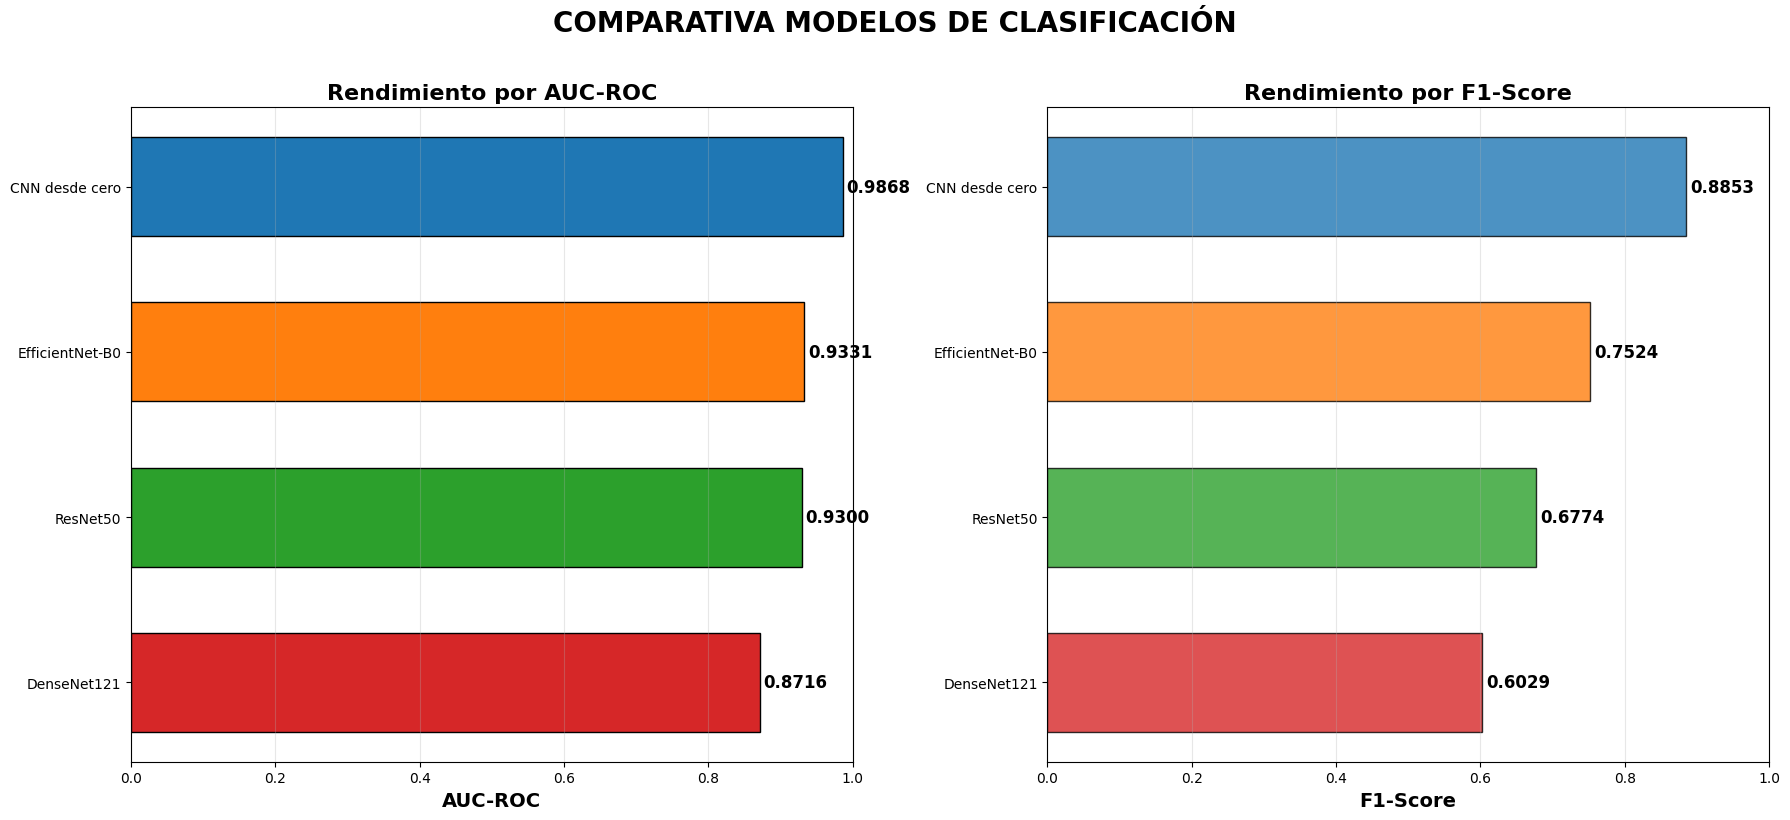

In [17]:
# Gráfico para comparar AUC-ROC y F1-Score

if 'df_results' in globals():
    # Creamos la figura con 2 Subplots Horizontales
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('COMPARATIVA MODELOS DE CLASIFICACIÓN', fontsize=20, fontweight='bold', y=1.02)
    
    # Definimos la paleta de colores que usaremos
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Gráfico 1, comparación por AUC-ROC
    bars1 = ax1.barh(df_results['model'], df_results['auc'], color=colors, edgecolor='black', height=0.6)
    ax1.set_xlabel('AUC-ROC', fontsize=14, fontweight='bold')
    ax1.set_title('Rendimiento por AUC-ROC', fontsize=16, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()  # Mejor modelo arriba
    
    # Añadimos el valor de cada uno en las barras
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', va='center', fontweight='bold', fontsize=12)
    
    # Gráfico 2, F1-Score
    bars2 = ax2.barh(df_results['model'], df_results['f1'], color=colors, alpha=0.8, edgecolor='black', height=0.6)
    ax2.set_xlabel('F1-Score', fontsize=14, fontweight='bold')
    ax2.set_title('Rendimiento por F1-Score', fontsize=16, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()
    
    # Añadimos el valor de cada uno en las barras
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{width:.4f}', va='center', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()